In [67]:
#import logging
from collections import namedtuple
import random
from typing import Callable
from copy import deepcopy
from itertools import accumulate
from operator import xor
import numpy as np
import matplotlib.pyplot as plt

In [68]:
Nimply = namedtuple("Nimply", "row, num_objects")

class Nim:
    def __init__(self, num_rows: int, k: int = None, player: int = random.randrange(2)) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k
        self._player = player

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def player(self) -> int:
        return self._player

    @property
    def k(self) -> int:
        return self._k

    # Simulating move to get possible future configuration
    def simulate_nimming(self, ply: Nimply):
        row, n = ply
        copy = list(self._rows)
        copy[row] -= n
        return tuple(copy)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
        self._player = 1 - self._player

    def get_state_and_reward(self):
        return tuple(self.rows), self.give_reward()

    def give_reward(self):
        # 0 if final position
        # -1 if ongoing position
        if self: return -1
        else: return 0

In [69]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result

def cook_status(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if state.k is None or o <= state.k
    ]
    cooked["active_rows_number"] = sum(o > 0 for o in state.rows)
    return cooked

In [70]:
def optimal_startegy(state: Nim) -> Nimply:
    data = cook_status(state)
    return next((bf for bf in data["brute_force"] if bf[1] == 0), random.choice(data["brute_force"]))[0]

def pure_random(state: Nim) -> Nimply:
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

In [71]:
class Agent(object):
    def __init__(self, states: Nim, alpha=0.15, random_factor=0.2):
        self.state_history = [(states.rows, 0)]  # state, reward
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(states)

    def init_reward(self, states: Nim):
        cooked = cook_status(states)
        if states.rows not in self.G: 
            self.G[states.rows] = np.random.uniform(low=1.0, high=0.1) 
            # logging.info(f"Added starting state! {self.G}")
        for m in cooked["possible_moves"]:
            new_state = states.simulate_nimming(m)
            if new_state not in self.G:
                self.G[new_state] = np.random.uniform(low=1.0, high=0.1)

    def choose_action(self, state: Nim):
        allowedMoves = cook_status(state)["possible_moves"]
        maxG = -10e15
        next_move = None
        randomN = np.random.random()
        if randomN < self.random_factor:
            # if random number below random factor, choose random action
            next_move = random.choice(allowedMoves)
        else:
            # if exploiting, gather all possible actions and choose one with the highest G (reward)
            for action in allowedMoves:
                new_state = state.simulate_nimming(action)
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

    def learn(self):
        target = 0
        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward
        self.state_history = []
        self.random_factor -= 10e-5  # decrease random factor each episode of play
            


0: Won 1 (1.00%) of the last 100 games
100: Won 38 (38.00%) of the last 100 games
200: Won 41 (41.00%) of the last 100 games
300: Won 33 (33.00%) of the last 100 games
400: Won 39 (39.00%) of the last 100 games
500: Won 35 (35.00%) of the last 100 games
600: Won 32 (32.00%) of the last 100 games
700: Won 36 (36.00%) of the last 100 games
800: Won 33 (33.00%) of the last 100 games
900: Won 35 (35.00%) of the last 100 games
1000: Won 32 (32.00%) of the last 100 games
1100: Won 31 (31.00%) of the last 100 games
1200: Won 44 (44.00%) of the last 100 games
1300: Won 33 (33.00%) of the last 100 games
1400: Won 29 (29.00%) of the last 100 games
1500: Won 36 (36.00%) of the last 100 games
1600: Won 40 (40.00%) of the last 100 games
1700: Won 32 (32.00%) of the last 100 games
1800: Won 40 (40.00%) of the last 100 games
1900: Won 47 (47.00%) of the last 100 games
2000: Won 40 (40.00%) of the last 100 games
2100: Won 26 (26.00%) of the last 100 games
2200: Won 39 (39.00%) of the last 100 games
23

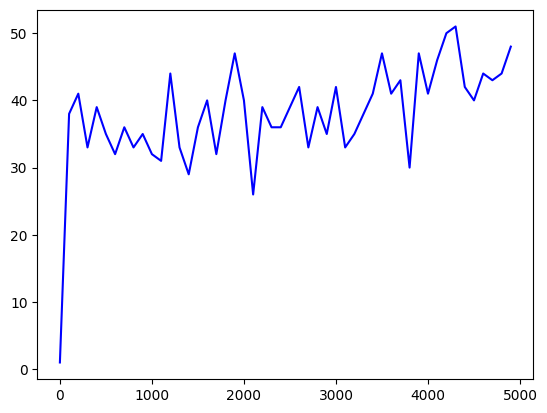

In [72]:
nim = Nim(11)
algo = Agent(nim, alpha=0.6, random_factor=0.5)
strategy = (pure_random, algo.choose_action)
winHistory = []
indices = []
games = 5000
wincount = 0

for i in range(games):
    while nim:
        ply = strategy[nim.player](nim)
        nim.nimming(ply)
        algo.init_reward(nim)
        state, reward = nim.get_state_and_reward()
        algo.update_state_history(state, reward)
    state, reward = nim.get_state_and_reward()
    algo.update_state_history(state, reward)
    if nim.player == 0: wincount += 1
    algo.learn()
    if i % 100 == 0:
        print(f"{i}: Won {wincount} ({wincount/100*100:.2f}%) of the last 100 games")
        winHistory.append(wincount/100*100)
        indices.append(i)
        wincount = 0
    nim = Nim(11)

plt.plot(indices, winHistory, "b")
plt.show()
